In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
infos = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
print(infos.columns)

Index(['Run', 'Cell', 's4U', 'Time', 'ActD', 'Barcode', 'UMI', 'Strain',
       'Cells', 'Group', 'LibStruct', 'Platform', 'Species', 'Remark',
       'Paternal', 'CellReads', 'TrimReads', 'TrimRatio', 'MappedReads',
       'MappedRatio', 'MitoRatio', 'FilteredReads', 'FilteredRatio',
       'FilteredClipReads', 'FilteredClipRatio', 'UMIs', 'UMIs2',
       'DuplicateReads', 'DuplicateRatio', 'UniqueReads', 'Isoforms',
       'Isoforms[Strict]', 'Genes', 'ACRatio', 'AGRatio', 'ATRatio', 'CARatio',
       'CGRatio', 'CTRatio', 'GARatio', 'GCRatio', 'GTRatio', 'TARatio',
       'TCRatio', 'TGRatio', 'Pe', 'Pc', 'Pc/Pe', 'UMIs2[Nascent2]',
       'NascentRatio2', 'Genes2', 'Genes2[Nascent2]'],
      dtype='object')


# Mismatch ratio

    K562
    mESC

In [2]:
ratios_rmdup = dict()
for path in glob.glob("../../1_NanoNASCseq/results/mismatch/ratio_rmdup/*/*.tsv"):
    cell = path.split("/")[-1][:-4]
    d = pd.read_csv(path, sep="\t")
    for t, r in d[["Type", "Ratio[NoSNP]"]].values:
        if "-" in t:
            continue
        t = "%s-%s" % (t[0], t[1])
        ratios_rmdup[(cell, t)] = r

In [3]:
ratios_consensus = dict()
for path in glob.glob("../../1_NanoNASCseq/results/mismatch/ratio_consensus/*/*.tsv"):
    if path.endswith(".events.tsv"):
        continue
    cell = path.split("/")[-1][:-4]
    d = pd.read_csv(path, sep="\t")
    for t, r in d[["Type", "Ratio"]].values:
        if "-" in t:
            continue
        t = "%s-%s" % (t[0], t[1])
        ratios_consensus[(cell, t)] = r

In [4]:
infos["TCRatio[Rmdup]"] = [ratios_rmdup.get((cell, "T-C"), np.nan) for cell in infos["Cell"]]
infos["TCRatio[Consensus]"] = [ratios_consensus.get((cell, "T-C"), np.nan) for cell in infos["Cell"]]

In [5]:
params = []
tmp = infos[(infos["Time"] == 3) & (np.isnan(infos["ActD"])) & (infos["UMIs"] >= 5000)]

d1 = tmp[(tmp["Strain"] == "K562") & (tmp["s4U"] == 0) & (tmp["TCRatio[Consensus]"] >= 0)]
d2 = tmp[(tmp["Strain"] == "K562") & (tmp["s4U"] == 50) & (tmp["TCRatio[Consensus]"] >= 0.008) & (tmp["TCRatio[Consensus]"] < 1)]
params.append(["K562", [0, 50], [d1, d2]])
print("K562 0uM 3h:", len(d1))
print("K562 50uM 3h:", len(d2))

d1 = tmp[(tmp["Strain"] == "mESC") & (tmp["s4U"] == 0) & (tmp["TCRatio[Consensus]"] >= 0)]
d2 = tmp[(tmp["Strain"] == "mESC") & (tmp["s4U"] == 400) & (tmp["TCRatio[Consensus]"] >= 0.010) & (tmp["TCRatio[Consensus]"] < 1)]
params.append(["mESC", [0, 400], [d1, d2]])
print("mESC 0uM 3h:", len(d1))
print("mESC 400uM 3h:", len(d2))

K562 0uM 3h: 190
K562 50uM 3h: 105
mESC 0uM 3h: 64
mESC 400uM 3h: 110


## 1. Mismatch ratio

--------------------------------------------------------------------------------
rmdup K562 0 50 190 105
Median of T-C ratio (%): 0.26579679610309487 1.4887188042050339
P-value (T-test): 1.8439337545337497e-144
P-value (Mann-Whitney U test): 3.4997189933552495e-46
--------------------------------------------------------------------------------
rmdup mESC 0 400 64 110
Median of T-C ratio (%): 0.27214685305413144 2.1381327500287926
P-value (T-test): 2.7159232274708603e-69
P-value (Mann-Whitney U test): 2.2776689006569123e-28
--------------------------------------------------------------------------------
consensus K562 0 50 190 105
Median of T-C ratio (%): 0.016653572903877055 1.2133164868767519
P-value (T-test): 1.1864713964594922e-140
P-value (Mann-Whitney U test): 3.4997189933552495e-46
--------------------------------------------------------------------------------
consensus mESC 0 400 64 110
Median of T-C ratio (%): 0.03573900984656244 1.9312702517059694
P-value (T-test): 3.25694715

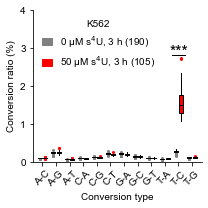

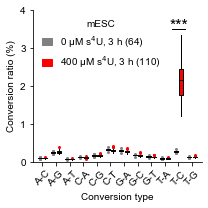

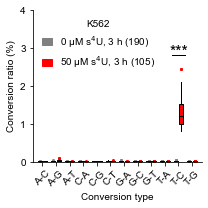

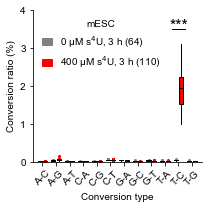

In [19]:
mtypes = ['A-C', 'A-G', 'A-T', 'C-A', 'C-G', 'C-T', 'G-A', 'G-C', 'G-T', 'T-A', 'T-C', 'T-G']

for name0, ratios in zip(["rmdup", "consensus"], [ratios_rmdup, ratios_consensus]):
    for name, (s4u_1, s4u_2), (d1, d2) in params:
        print("-" * 80)
        print(name0, name, s4u_1, s4u_2, len(d1), len(d2))

        xs = np.arange(len(mtypes))
        ys1 = [[ratios[(cell, mtype)] * 100 for cell in d1["Cell"]] for mtype in mtypes]
        ys2 = [[ratios[(cell, mtype)] * 100 for cell in d2["Cell"]] for mtype in mtypes]

        plt.figure(figsize=(3, 3))
        box1 = plt.boxplot(ys1, positions=xs - 0.2, widths=0.3, patch_artist=True, 
                           showcaps=False, 
                           boxprops={"facecolor": "grey"},
                           medianprops={"color": "black"},
                           showfliers=True, 
                           flierprops={"markerfacecolor": "grey", "markeredgecolor": "none", "marker": "."})
        box2 = plt.boxplot(ys2, positions=xs + 0.2, widths=0.3, patch_artist=True, 
                           showcaps=False, 
                           boxprops={"facecolor": "red"},
                           medianprops={"color": "black"},
                           showfliers=True, 
                           flierprops={"markerfacecolor": "red", "markeredgecolor": "none", "marker": "."})
        print("Median of T-C ratio (%):", np.median(ys1[10]), np.median(ys2[10]))
        pvalue = ttest_ind(ys1[10], ys2[10])[1]
        print("P-value (T-test):", pvalue)
        assert pvalue < 0.00001
        pvalue = mannwhitneyu(ys1[10], ys2[10])[1]
        print("P-value (Mann-Whitney U test):", pvalue)

        y = 2.8
        if name == "mESC":
            y = 3.5
        plt.plot([10 - 0.5, 10 + 0.5], [y, y], lw=1, color="black")
        plt.text(10, y + 0.1, "***", va="center", ha="center", size=16)
        #plt.title(name)
        #plt.text(5, 3.6, name)
        plt.ylim(0, 4)
        ticks = ["%s-%s" % (mt[0], mt[2]) for mt in mtypes]
        plt.xticks(xs, ticks, rotation=45)
        plt.yticks([0, 1, 2, 3, 4])
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.xlabel("Conversion type")
        plt.ylabel("Conversion ratio (%)")
        patch1 = mpatches.Patch(color='grey', label='%d μM s$^4$U, 3 h (%d)' % (s4u_1, len(d1)))
        patch2 = mpatches.Patch(color='red', label='%d μM s$^4$U, 3 h (%d)' % (s4u_2, len(d2)))
        plt.legend(loc="upper left", handles=[patch1, patch2], handlelength=1, frameon=False, title=name)
        plt.tight_layout()
        plt.savefig("figures/mismatch_ratio.%s.%s.pdf" % (name, name0), dpi=300)
        # break

# Mismatch ratio (time)

Cells: [167, 32, 51, 41, 44, 161]


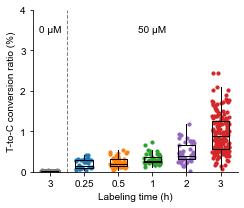

In [38]:
tmp = infos[(infos["Strain"] == "K562") & (infos["UMIs"] >= 5000) & (np.isnan(infos["ActD"]))]
tmp = tmp[tmp["Run"] != "20221014_K562R1"]
tmp = tmp[tmp["Run"] != "20221014_K562R2"]
ds = []
ds.append(tmp[(tmp["s4U"] == 0) & (tmp["Time"] == 3)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 0.25)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 0.5)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 1)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 2)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 3)])
print("Cells:", [len(d) for d in ds])

np.random.seed(0)
colors = ["grey", "C0", "C1", "C2", "C4", "C3", "grey", "grey", "grey", "grey"]
w = 0.5
plt.figure(figsize=(3.5, 3))
for i, d in enumerate(ds):
    vs = d["TCRatio[Consensus]"].values * 100
    plt.boxplot(vs, positions=[i], widths=w, 
                showfliers=False, showcaps=False, medianprops={"color": "black"})
    xs = np.random.random(len(vs)) * w - w/2 + i
    plt.scatter(xs, vs, marker="o", s=10, color=colors[i])

ylim = 4
plt.text(0, ylim * 0.85, "0 μM", ha="center", va="bottom")
plt.text(3, ylim * 0.85, "50 μM", ha="center", va="bottom")
plt.axvline(0.5, lw=1, ls="--", color="grey")

plt.xlabel("Labeling time (h)")
plt.ylabel("T-to-C conversion ratio (%)")
plt.xticks(np.arange(len(ds)), ["3", "0.25", "0.5", "1", "2", "3"])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(-0.5, 5.5)
plt.ylim(0, ylim)
plt.yticks([0, 1, 2, 3, 4])
plt.tight_layout()
plt.savefig("figures/mismatch_ratio.time.pdf", dpi=300)

# Mismatch ratio (ActD treatment)

Cells: [167, 161, 68, 63, 81, 59]


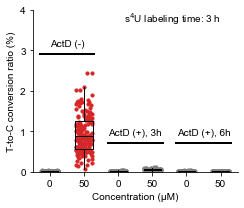

In [2]:
mtypes = ['AC', 'AG', 'AT', 'CA', 'CG', 'CT', 'GA', 'GC', 'GT', 'TA', 'TC', 'TG']
tmp = infos[(infos["Strain"] == "K562") & (infos["UMIs"] >= 5000)]
tmp = tmp[tmp["Run"] != "20221014_K562R1"] # R10.4.1
tmp = tmp[tmp["Run"] != "20221014_K562R2"]   
ds = list()
ds.append(tmp[(tmp["s4U"] == 0) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))])
ds.append(tmp[(tmp["s4U"] == 0) & (tmp["Time"] == 3) & (tmp["ActD"] == 3)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 3) & (tmp["ActD"] == 3)])
ds.append(tmp[(tmp["s4U"] == 0) & (tmp["Time"] == 3) & (tmp["ActD"] == 6)])
ds.append(tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 3) & (tmp["ActD"] == 6)])
print("Cells:", [len(d) for d in ds])

np.random.seed(0)
colors = ["grey", "C3", "grey", "grey", "grey", "grey"]
w = 0.5
plt.figure(figsize=(3.5, 3))
for i, d in enumerate(ds):
    vs = d["TCRatio"].values * 100
    plt.boxplot(vs, positions=[i], widths=w, 
                showfliers=False, showcaps=False, medianprops={"color": "black"})
    xs = np.random.random(len(vs)) * w - w/2 + i
    plt.scatter(xs, vs, marker="o", s=10, color=colors[i])
plt.text(5, 3.7, "s$^4$U labeling time: 3 h", ha="right")
plt.ylabel("T-to-C conversion ratio (%)")
plt.xticks(np.arange(len(ds)), ["0", "50", "0", "50", "0", "50"])
plt.xlabel("Concentration (μM)")
plt.text(0.5, 3.1, "ActD (-)", ha="center")
plt.text(2.5, 0.9, "ActD (+), 3h", ha="center")
plt.text(4.5, 0.9, "ActD (+), 6h", ha="center")
plt.plot([0 - 0.3, 1 + 0.3], [2.9, 2.9], lw=2, color="black")
plt.plot([2 - 0.3, 3 + 0.3], [0.7, 0.7], lw=2, color="black")
plt.plot([4 - 0.3, 5 + 0.3], [0.7, 0.7], lw=2, color="black")
if False:
    for x in [1.5, 3.5]:
        plt.plot([x, x], [0, 3.6], lw=1, ls="--", color="grey")
    for x, y, pval_marker in zip([0, 2, 4], [2.8, 0.8, 0.8], ["***", "NS", "NS"]):
        x1, x2 = x - 0.3, x + 0.3 + 1
        y1, y2 = y, y - 0.1
        plt.plot([x1, x1], [y1, y2], lw=1, color="black")
        plt.plot([x2, x2], [y1, y2], lw=1, color="black")
        plt.plot([x1, x2], [y1, y1], lw=1, color="black")
        if pval_marker == "NS":
            plt.text(x + 0.5, y1 + 0.1, pval_marker, ha="center")
        else:
            plt.text(x + 0.5, y1, pval_marker, ha="center", size=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(-0.5, 5.5)
plt.ylim(0, 4)
plt.yticks([0, 1, 2, 3, 4])
plt.tight_layout()
plt.savefig("figures/mismatch_ratio.actd.pdf", dpi=300)

In [3]:
pvalue1 = ttest_ind(ds[0]["TCRatio"].values, ds[1]["TCRatio"].values)[1]
pvalue2 = ttest_ind(ds[2]["TCRatio"].values, ds[3]["TCRatio"].values)[1]
pvalue3 = ttest_ind(ds[4]["TCRatio"].values, ds[5]["TCRatio"].values)[1]
print(pvalue1, pvalue2, pvalue3)

1.6088384264638316e-79 1.7661615854221625e-19 0.42065541499244563


# Mismatch ratio (concentration)

## 1. K562

Cells:	[23, 18, 19, 11, 17, 23]
Mann-Whitney U test: 0.49561475955411016
Mann-Whitney U test: 2.9005409119525837e-08
Mann-Whitney U test: 1.8044678039202207e-08
Mann-Whitney U test: 1.7557028052633155e-06
Mann-Whitney U test: 4.773831934863488e-08
Mann-Whitney U test: 3.3184428214986893e-09


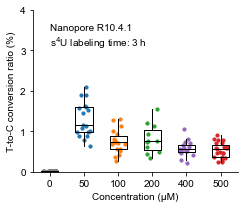

In [34]:
tmp = infos[(infos["Strain"] == "K562") & (infos["Time"] == 3) & (np.isnan(infos["ActD"])) \
            & (infos["UMIs"] >= 5000) \
            & ((infos["Run"] == "20221014_K562R1") | (infos["Run"] == "20221014_K562R2"))]
ds = []
ds.append(tmp[tmp["s4U"] == 0])
ds.append(tmp[tmp["s4U"] == 50])
ds.append(tmp[tmp["s4U"] == 100])
ds.append(tmp[tmp["s4U"] == 200])
ds.append(tmp[tmp["s4U"] == 400])
ds.append(tmp[tmp["s4U"] == 500])
print("Cells:", [len(d) for d in ds], sep="\t")

np.random.seed(0)
colors = ["grey", "C0", "C1", "C2", "C4", "C3", "grey", "grey", "grey", "grey"]
w = 0.5
plt.figure(figsize=(3.5, 3))
for i, d in enumerate(ds):
    vs = d["TCRatio[Consensus]"].values * 100
    if True:
        vs0 = ds[0]["TCRatio[Consensus]"].values * 100
        pvalue = mannwhitneyu(vs0, vs)[1]
        print("Mann-Whitney U test:", pvalue)
    plt.boxplot(vs, positions=[i], widths=w, 
                showfliers=False, showcaps=False, medianprops={"color": "black"})
    xs = np.random.random(len(vs)) * 0.4 - 0.2 + i
    plt.scatter(xs, vs, marker="o", s=10, color=colors[i])
plt.text(0, 3.5, "Nanopore R10.4.1")
plt.text(0, 3.1, "s$^4$U labeling time: 3 h", ha="left")
plt.xlabel("Concentration (μM)")
plt.ylabel("T-to-C conversion ratio (%)")
plt.xticks(np.arange(len(ds)), ["0", "50", "100", "200", "400", "500"])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(-0.5, 5.5)
plt.ylim(-0.0, 4)
plt.yticks([0, 1, 2, 3, 4])
plt.tight_layout()
plt.savefig("figures/mismatch_ratio.concentration.pdf", dpi=300)

In [35]:
for i, d in enumerate(ds):
    vs0 = ds[1]["TCRatio"].values * 100
    vs1 = ds[i]["TCRatio"].values * 100
    pvalue = mannwhitneyu(vs0, vs1)[1]
    print("Mann-Whitney U test:", pvalue)

Mann-Whitney U test: 2.9005409119525837e-08
Mann-Whitney U test: 0.4936819537906939
Mann-Whitney U test: 9.86729874215723e-05
Mann-Whitney U test: 0.002852957644468009
Mann-Whitney U test: 1.7658801908600934e-06
Mann-Whitney U test: 1.2208227671329583e-07


## 2. mESC

    只有0，50和400uM的浓度

In [36]:
tmp = infos[(infos["Strain"] == "mESC") \
          & (infos["Platform"] == "R10") \
          & (infos["Cells"] == 1) \
          & (infos["UMI"] == 20) \
          & (infos["LibStruct"] == "struct2")]
d1 = tmp[(tmp["s4U"] == 0) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))]
d2 = tmp[(tmp["s4U"] == 50) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))]
d3 = tmp[(tmp["s4U"] == 100) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))]
d4 = tmp[(tmp["s4U"] == 200) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))]
d5 = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))]
d6 = tmp[(tmp["s4U"] == 500) & (tmp["Time"] == 3) & (np.isnan(tmp["ActD"]))]
ds = [d1, d2, d3, d4, d5, d6]
print(len(d1), len(d2), len(d3), len(d4), len(d5), len(d6), sep="\t")

64	82	0	0	42	0
